# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import skew

%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

# Load in the customers subset file.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape


(891221, 85)

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
feat_info.head(20)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [6]:
# Identify missing or unknown data values and convert them to NaNs.
for feat in range(len(feat_info)):
    m_and_u = feat_info.iloc[feat]['missing_or_unknown']
    m_and_u = m_and_u.strip('[')
    m_and_u = m_and_u.strip(']')
    m_and_u = m_and_u.split(sep=',')
    m_and_u = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in m_and_u]
    if m_and_u != ['']:
        azdias = azdias.replace({feat_info.iloc[feat]['attribute']: m_and_u}, np.nan)

In [7]:
# Check shape, missing data and datatype
azdias.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
total = azdias.shape[0]
total_nulls = azdias.isnull().sum()
percent_null = total_nulls/total
null_sum = pd.concat([total_nulls,percent_null], axis=1, keys=['Total','Percent'])


Text(0.5, 0, 'Percent Missing')

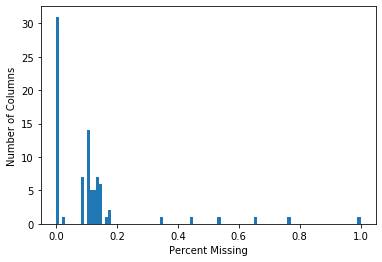

In [9]:
plt.hist(null_sum.Percent, bins=100, range=(0,1))
plt.ylabel('Number of Columns')
plt.xlabel('Percent Missing')

In [10]:
top_nulls = null_sum.sort_values(by='Percent', ascending=False).head(40)
top_nulls

,Total,Percent
TITEL_KZ,889061,0.997576
AGER_TYP,685843,0.769554
KK_KUNDENTYP,584612,0.655967
KBA05_BAUMAX,476524,0.534687
GEBURTSJAHR,392318,0.440203
ALTER_HH,310267,0.348137
KKK,158064,0.177357
REGIOTYP,158064,0.177357
W_KEIT_KIND_HH,147988,0.166051
KBA05_ANTG1,133324,0.149597


In [11]:
top_nulls.index

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH', 'KKK', 'REGIOTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO',
       'PLZ8_ANTG3', 'PLZ8_ANTG2', 'PLZ8_GBZ', 'PLZ8_HHZ', 'PLZ8_ANTG1',
       'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'VERS_TYP', 'HEALTH_TYP', 'SHOPPER_TYP',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'KBA13_ANZAHL_PKW',
       'ANZ_HAUSHALTE_AKTIV', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015',
       'CAMEO_DEUG_2015', 'LP_LEBENSPHASE_FEIN', 'ARBEIT', 'RELAT_AB',
       'ORTSGR_KLS9', 'ANZ_HH_TITEL', 'LP_LEBENSPHASE_GROB', 'INNENSTADT',
       'EWDICHTE'],
      dtype='object')

In [12]:
transform = null_sum.reset_index()
null_sum = transform.rename(columns={'index':'attribute'})

In [13]:
null_sum = null_sum.merge(feat_info)

In [14]:
null_sum.sort_values(by="Total", ascending=False).head(25)

,attribute,Total,Percent,information_level,type,missing_or_unknown
40,TITEL_KZ,889061,0.997576,person,categorical,"[-1,0]"
0,AGER_TYP,685843,0.769554,person,categorical,"[-1,0]"
47,KK_KUNDENTYP,584612,0.655967,household,categorical,[-1]
64,KBA05_BAUMAX,476524,0.534687,microcell_rr3,mixed,"[-1,0]"
11,GEBURTSJAHR,392318,0.440203,person,numeric,[0]
43,ALTER_HH,310267,0.348137,household,interval,[0]
70,KKK,158064,0.177357,region_rr1,ordinal,"[-1,0]"
73,REGIOTYP,158064,0.177357,region_rr1,ordinal,"[-1,0]"
48,W_KEIT_KIND_HH,147988,0.166051,household,ordinal,"[-1,0]"
60,KBA05_ANTG1,133324,0.149597,microcell_rr3,ordinal,[-1]


In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias = azdias.drop(columns= ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'])

#### Discussion 1.1.2: Assess Missing Data in Ea
Most columns seem to be 20% or less data. Columns with more missing data are outliers. Given more than 20% seems to be a significantly large amount of missing data, I am going to drop these columns.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Text(0.5, 0, 'Number Missing')

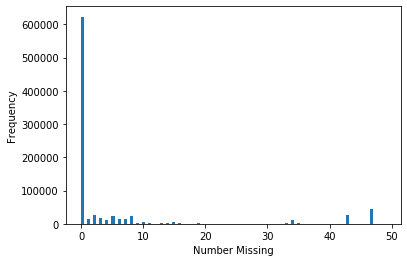

In [16]:
# How much data is missing in each row of the dataset?
rtotal = azdias.shape[1]
rtotal_nulls = azdias.isnull().sum(axis=1)
rpercent_null = rtotal_nulls/rtotal
rnull_sum = pd.concat([rtotal_nulls,rpercent_null], axis=1, keys=['Total','Percent'])
plt.hist(rnull_sum.Total, bins=100, range=(0,rnull_sum.Total.max()))
plt.ylabel('Frequency')
plt.xlabel('Number Missing')


In [17]:
rnull_sum[rnull_sum.Percent <.10].sort_values(by='Percent', ascending = False)

,Total,Percent
268489,7,0.088608
727321,7,0.088608
727302,7,0.088608
195081,7,0.088608
195110,7,0.088608
581962,7,0.088608
368390,7,0.088608
195151,7,0.088608
368373,7,0.088608
581998,7,0.088608


In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_no_null = azdias[azdias.isnull().sum(axis=1) <= 8]
azdias_nulls = azdias[azdias.isnull().sum(axis=1) > 8]
no_nulls = null_sum[null_sum.Total==0].attribute.tolist()

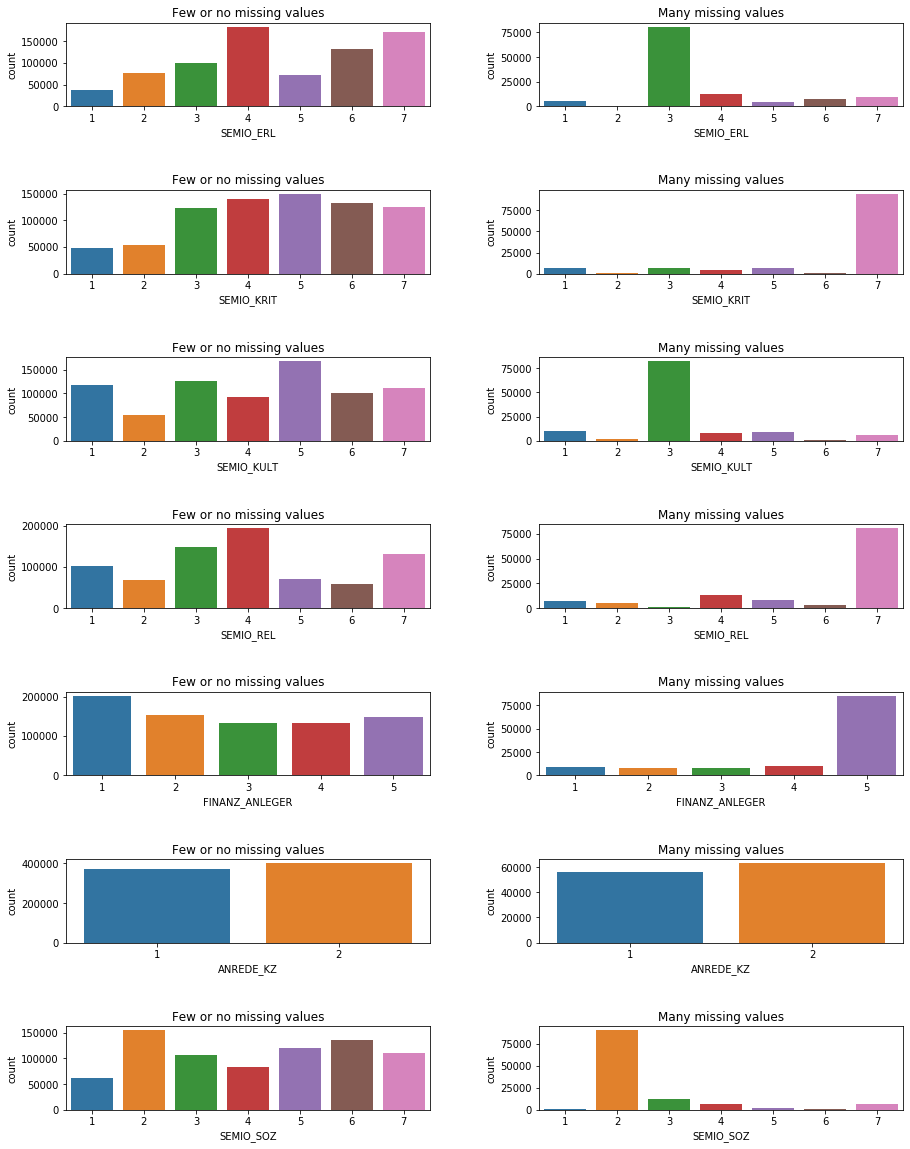

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
import random

cols_to_compare = random.sample(no_nulls,7)

figure, axs = plt.subplots(nrows=len(cols_to_compare), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 1, wspace=.3)
for i in range(len(cols_to_compare)):
    sns.countplot(azdias_no_null[cols_to_compare[i]], ax=axs[i][0])
    axs[i][0].set_title('Few or no missing values')
    sns.countplot(azdias_nulls[cols_to_compare[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

Rows with more missing values appear to be more skewed towards one particular values. Rows with no missing values, although they may still be skewed, appear to have a more balanced proportion of values. 

Missing data in column totals seems to be equal across categories. For example, "KBAO5_", "PLZ8_", and other variables belonging to groups all have the same number of missing data as other members in their group.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?
features = list(azdias_no_null.columns)
feat_info_clean = feat_info[feat_info['attribute'].isin(features)]
d_types_count = feat_info_clean['type'].value_counts()
for i in range(len(d_types_count)):
    print('There are {} {} features.'.format(d_types_count[i], d_types_count.index[i]))

There are 49 ordinal features.
There are 18 categorical features.
There are 6 numeric features.
There are 6 mixed features.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_features = feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
numerical_features = feat_info_clean[feat_info_clean["type"]=="numeric"]["attribute"]
ordinal_features = feat_info_clean[feat_info_clean["type"]=="ordinal"]["attribute"]
mixed_features = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]


In [22]:
# Re-encode binary categorical variable(s) to be kept in the analysis.
binary_feature = []
multi_level_feature=[]
for feature in cat_features:
    if (len(azdias_no_null[feature].unique())==2):
        binary_feature.append(feature)
    elif (len(azdias_no_null[feature].unique())>2):
        multi_level_feature.append(feature)

In [23]:
for feature in binary_feature:
    print('{} uniques: {}'.format(feature, azdias_no_null[feature].unique()))


ANREDE_KZ uniques: [2 1]
GREEN_AVANTGARDE uniques: [0 1]
SOHO_KZ uniques: [1. 0.]
OST_WEST_KZ uniques: ['W' 'O']


In [24]:
new_values = {'W': 0, 'O': 1}
azdias_clean = azdias_no_null.replace({'OST_WEST_KZ':new_values})

In [25]:
# Re-encode multi-level categorical variable(s) to be kept in the analysis.

#create dummy variables for household types
df = pd.get_dummies(azdias_clean['LP_FAMILIE_GROB'])
df = df.rename(columns={1:'SINGLE', 2:'COUPLE', 3:'SINGLE_PARENT', 4:'FAMILY', 5:'MULTI_HOUSEHOLD'})
azdias_clean = pd.concat([azdias_clean, df], axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

I decided to discard most of the categorical variables. Many variables' values were not mutually exclusive of each other. For example, 'GFK_URLAUBERTYP', which describes vacation habits lists 'Hiker' and 'Active Family'. Other values like 'GEBURTSJAHR' (year of birth) can be found elsewhere in the data set. I did the kept the variable 'LP_FAMILIE_GROB', which described household status. To re-engineer the variable, I used one-hot encoding to create dummy variables for each possible household status. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, CULT_BELIEF (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for CULT_BELIEF.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#recategorize mixed variables into single scale variables - decade, CULT_BELIEF, wealth, lifestage, rural neighberhood, family homes, and business
azdias_clean['DECADE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']
azdias_clean['CULT_BELIEF'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']

decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
CULT_BELIEF_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

azdias_clean['DECADE'].replace(decade_dict, inplace=True)
azdias_clean['CULT_BELIEF'].replace(CULT_BELIEF_dict, inplace=True)

azdias_clean['WEALTH'] = azdias_clean['CAMEO_INTL_2015']
azdias_clean['FAM_STAGE'] = azdias_clean['CAMEO_INTL_2015']

wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

FAM_STAGE_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

azdias_clean['WEALTH'].replace(wealth_dict, inplace=True)
azdias_clean['FAM_STAGE'].replace(FAM_STAGE_dict, inplace=True)

neighberhood_dict = {1:0, 2:0, 3:0, 4:0, 5:0, 7:1, 8:1}


azdias_clean['RURAL_NEIGHBERHOOD'] = azdias_clean['WOHNLAGE']
azdias_clean['RURAL_NEIGHBERHOOD'].replace(neighberhood_dict, inplace=True)


fam_homes_dict = {5:0}
business_dict = {1:0 ,2:0 ,3:0 ,4:0 , 5:1}

azdias_clean['FAMILY_HOMES'] = azdias_clean['PLZ8_BAUMAX']
azdias_clean['FAMILY_HOMES'].replace(fam_homes_dict, inplace=True)


azdias_clean['BUSINESS'] = azdias_clean['PLZ8_BAUMAX']
azdias_clean['BUSINESS'].replace(business_dict, inplace=True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

I checked each mixed variable. Many of the variables contained data that could already be found within the data elsewhere. For example, 'LP_LEBENSPHASE_FEIN' describes age and income, two variables that are accounted for elsewhere. I created variables for 'WOHLAGE & 'PLZ8_BAUMAX'' to create binary and numerical variables that I couldn't find in the data set elsewhere. These included rural vs urban, business vs home, & number of family homes.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [27]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#log transform any skewed numerical values - though there are none
azdias_num = azdias_clean.loc[:,numerical_features]

skewness = azdias_num.apply(lambda x: skew(x))
skewness = skewness.loc[abs(skewness) > 1]

skewed_features = skewness.index
azdias_clean.loc[:,skewed_features] = np.log1p(azdias_num.loc[:,skewed_features])


    

In [28]:
#create a list for ordinal, categorical, and numerical variables, and add newly created values to each of the lists
cat_list = cat_features.tolist()
cat_list.extend(['RURAL_NEIGHBERHOOD', 'BUSINESS', 'SINGLE', 'COUPLE', 'SINGLE_PARENT', 'FAMILY', 'MULTI_HOUSEHOLD'])

ord_list = ordinal_features.tolist()
ord_list.extend(['WEALTH', 'FAM_STAGE','DECADE','CULT_BELIEF','FAMILY_HOMES'])



In [29]:
#for null values, impute most frequent to ordinal, mean to numerical, and 0 to categorical values
fill_ord_missing = Imputer(strategy = 'most_frequent')
fill_num_missing = Imputer(strategy = 'mean')


ord_cols = azdias_clean.loc[:,ord_list]
num_cols = azdias_clean.loc[:, numerical_features]
cat_cols = azdias_clean.loc[:, cat_list]

azdias_ord_clean = pd.DataFrame(fill_ord_missing.fit_transform(ord_cols))
azdias_ord_clean.columns = ord_cols.columns
azdias_ord_clean.index = ord_cols.index

azdias_num_clean = pd.DataFrame(fill_num_missing.fit_transform(num_cols))
azdias_num_clean.columns = num_cols.columns
azdias_num_clean.index = num_cols.index

azdias_cat_clean = cat_cols.fillna(0)

azdias_clean_imputed = pd.concat([azdias_cat_clean,azdias_num_clean,azdias_ord_clean], axis=1)

In [30]:
#drop all multi categorical columns except for the below. these two columns are actually ordinal.

multi_cat_keep = ['CAMEO_DEUG_2015', 'LP_STATUS_GROB']

for column in multi_level_feature:
    if column not in multi_cat_keep:
        azdias_clean_imputed = azdias_clean_imputed.drop(columns=column)
        

In [31]:
#drop irrelevant columns. this column gives the date the data was entered.

azdias_clean_imputed = azdias_clean_imputed.drop(columns='MIN_GEBAEUDEJAHR')


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for indx in range(len(feat_info)):
        m_and_u = feat_info.iloc[indx]['missing_or_unknown']
        m_and_u = m_and_u.strip('[')
        m_and_u = m_and_u.strip(']')
        m_and_u = m_and_u.split(sep=',')
        m_and_u = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in m_and_u]
        if m_and_u != ['']:
            df_clean = df.replace({feat_info.iloc[indx]['attribute']: m_and_u}, np.nan)
    
    for col in df.columns:
        df_clean = df_clean.replace({col: ['XX', 'X']}, np.nan)
    # remove selected columns and rows, ...
    # drop columns with more than 20% missing values
    columns_miss_20 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_clean = df_clean.drop(columns_miss_20, axis=1)
    # drop rows with more than 3 missing values
    df_clean = df_clean[df_clean.isnull().sum(axis=1) <= 3]
    # select, re-encode, and engineer column values.

    # re-encode binary feature
    new_values = {'W': 0, 'O': 1}
    df_clean = df_clean.replace({'OST_WEST_KZ':new_values})
    
    # drop multi-leve features
    cat_features = feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
    multi_level_feature=[]
    for feature in cat_features:
        if (len(azdias_no_null[feature].unique())>2):
            multi_level_feature.append(feature)
    #for feature in multi_level_feature:
    #    df_clean=df_clean.drop(feature, axis=1)
    
    # engineer mixed features
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean['CULT_BELIEF'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    CULT_BELIEF_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    
    df_clean['DECADE'].replace(decade_dict, inplace=True)
    df_clean['CULT_BELIEF'].replace(CULT_BELIEF_dict, inplace=True)
    
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']
    df_clean['FAM_STAGE'] = df_clean['CAMEO_INTL_2015']
    
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}
    
    FAM_STAGE_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    
    df_clean['WEALTH'].replace(wealth_dict, inplace=True)
    df_clean['FAM_STAGE'].replace(FAM_STAGE_dict, inplace=True)
    
    df_clean['RURAL_NEIGHBERHOOD'] = df_clean['WOHNLAGE']

    neighberhood_dict = {1:0, 2:0, 3:0, 4:0, 5:0, 7:1, 8:1}

    df_clean['RURAL_NEIGHBERHOOD'].replace(neighberhood_dict, inplace=True)

    df_clean['FAMILY_HOMES'] = df_clean['PLZ8_BAUMAX']
    df_clean['BUSINESS'] = df_clean['PLZ8_BAUMAX']

    fam_homes_dict = {5:0}
    
    business_dict = {1:0 ,2:0 ,3:0 ,4:0 , 5:1}

    df_clean['FAMILY_HOMES'].replace(fam_homes_dict, inplace=True)
    df_clean['BUSINESS'].replace(business_dict, inplace=True)
    
    dummy_df = pd.get_dummies(df_clean['LP_FAMILIE_GROB'])
    dummy_df = dummy_df.rename(columns={1:'SINGLE', 2:'COUPLE', 3:'SINGLE_PARENT', 4:'FAMILY', 5:'MULTI_HOUSEHOLD'})
    
    df_clean = pd.concat([df_clean, dummy_df], axis=1)
    
    cat_list = cat_features.tolist()
    cat_list.extend(['RURAL_NEIGHBERHOOD', 'BUSINESS', 'SINGLE', 'COUPLE', 'SINGLE_PARENT', 'FAMILY', 'MULTI_HOUSEHOLD'])

    ord_list = ordinal_features.tolist()
    ord_list.extend(['WEALTH', 'FAM_STAGE','DECADE','CULT_BELIEF','FAMILY_HOMES'])

    ord_cols = df_clean.loc[:,ord_list]
    num_cols = df_clean.loc[:, numerical_features]
    cat_cols = df_clean.loc[:, cat_list]

    df_ord_clean = pd.DataFrame(fill_ord_missing.transform(ord_cols))
    df_ord_clean.columns = ord_cols.columns
    df_ord_clean.index = ord_cols.index

    df_num_clean = pd.DataFrame(fill_num_missing.transform(num_cols))
    df_num_clean.columns = num_cols.columns
    df_num_clean.index = num_cols.index

    df_cat_clean = cat_cols.fillna(0)

    df_clean = pd.concat([df_cat_clean,df_num_clean,df_ord_clean], axis=1)
    
    #mixed_features = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
    #for feature in mixed_features:
    #    df_clean.drop(feature, axis=1, inplace=True)
    
    
    multi_cat_keep = ['CAMEO_DEUG_2015', 'LP_STATUS_GROB']

    for column in multi_level_feature:
        if column not in multi_cat_keep:
            df_clean = df_clean.drop(column, axis=1)

    df_clean = df_clean.drop('MIN_GEBAEUDEJAHR', axis=1)

    # Return the cleaned dataframe.
    return df_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [33]:
#I applied an imputer at the end of Step 1.2.3 - 'Complete Feature Selection.' I found it easier to keep track of new columns to include and what columns to drop by imputing values and then dropping

In [34]:
azdias_clean_imputed.head()

,ANREDE_KZ,GREEN_AVANTGARDE,LP_STATUS_GROB,SOHO_KZ,OST_WEST_KZ,CAMEO_DEUG_2015,RURAL_NEIGHBERHOOD,BUSINESS,SINGLE,COUPLE,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,WEALTH,FAM_STAGE,DECADE,CULT_BELIEF,FAMILY_HOMES
1,2,0,1.0,1.0,0,8,0.0,0.0,0,0,...,5.0,4.0,3.0,5.0,4.0,5.0,1.0,6.0,1.0,1.0
2,2,1,2.0,0.0,0,4,0.0,0.0,1,0,...,4.0,4.0,3.0,5.0,2.0,2.0,4.0,6.0,0.0,1.0
3,2,0,4.0,0.0,0,2,1.0,0.0,0,0,...,3.0,4.0,2.0,3.0,3.0,1.0,2.0,4.0,1.0,1.0
4,1,0,2.0,0.0,0,6,0.0,0.0,0,0,...,3.0,3.0,4.0,6.0,5.0,4.0,3.0,4.0,1.0,2.0
5,2,0,2.0,0.0,0,8,1.0,0.0,1,0,...,5.0,5.0,2.0,3.0,3.0,5.0,4.0,2.0,1.0,1.0


In [35]:
scaler = RobustScaler() 
azdias_clean_scaled = scaler.fit_transform(azdias_clean_imputed)

### Discussion 2.1: Apply Feature Scaling

I used different imputation methods depending on the data type. For numerical data types, the range of values is much larger, so I decided to use a mean. Ordinal values are typically on a smaller scale, so I decided to use the most frequent value for these. Lastly, for binary variables, typically empty implies 'no' or 'not applicable', so I replaced nulls with zeroes. 

Afterwards I applied a standard scaler fit the all of the data fields.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [36]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_clean_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

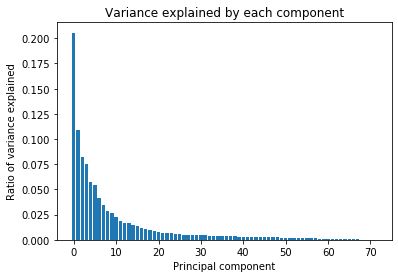

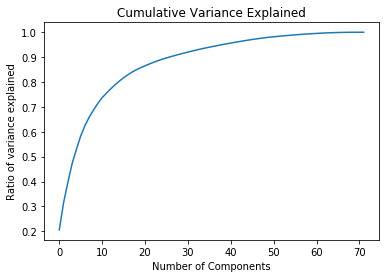

In [37]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()


In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_40 = PCA(n_components=40)
azdias_pca = pca_40.fit_transform(azdias_clean_scaled)


### Discussion 2.2: Perform Dimensionality Reduction
I chose to use 40 components, as it explains approximately 95% of variance, while nearly halfing the total number of variables.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=azdias_clean_imputed.columns.tolist())
    weights = df.iloc[i].sort_values(ascending=False)
    return weights


In [40]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_0 = pca_weights(pca_40, 0)
print (pca_weight_0.head(10),pca_weight_0.tail(10))


ANZ_HAUSHALTE_AKTIV    0.479017
PLZ8_ANTG3             0.269079
PLZ8_ANTG4             0.197384
ORTSGR_KLS9            0.181290
HH_EINKOMMEN_SCORE     0.179084
ARBEIT                 0.170816
PLZ8_ANTG2             0.163749
KBA05_ANTG3            0.145837
FINANZ_HAUSBAUER       0.141056
KBA05_ANTG4            0.131293
Name: 0, dtype: float64 LP_STATUS_GROB       -0.126760
INNENSTADT           -0.130819
GEBAEUDETYP_RASTER   -0.140338
FINANZ_MINIMALIST    -0.149919
KONSUMNAEHE          -0.153835
WOHNDAUER_2008       -0.169593
KBA05_GBZ            -0.172429
MOBI_REGIO           -0.199659
PLZ8_GBZ             -0.244753
PLZ8_ANTG1           -0.269580
Name: 0, dtype: float64


In [41]:
pca_weight_1 = pca_weights(pca_40, 1)
print(pca_weight_1.head(10),pca_weight_1.tail(10))

WOHNDAUER_2008          0.762952
ANZ_HAUSHALTE_AKTIV     0.205501
ALTERSKATEGORIE_GROB    0.147543
SEMIO_ERL               0.135406
FINANZ_VORSORGER        0.119124
SEMIO_LUST              0.108044
FINANZ_MINIMALIST       0.099670
RETOURTYP_BK_S          0.085740
KBA05_ANTG4             0.048901
PLZ8_ANTG3              0.044769
Name: 1, dtype: float64 SEMIO_MAT               -0.110178
FINANZ_ANLEGER          -0.110674
FINANZ_UNAUFFAELLIGER   -0.119225
SEMIO_KULT              -0.129780
DECADE                  -0.133059
FINANZ_SPARER           -0.135393
SEMIO_TRADV             -0.149070
SEMIO_PFLICHT           -0.160479
SEMIO_RAT               -0.179415
SEMIO_REL               -0.257324
Name: 1, dtype: float64


In [42]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_2 = pca_weights(pca_40, 2)
print (pca_weight_2.head(10),pca_weight_2.tail(10))


ANZ_HAUSHALTE_AKTIV    0.767174
PLZ8_ANTG1             0.182426
PLZ8_GBZ               0.141570
KBA13_ANZAHL_PKW       0.101562
KBA05_ANTG4            0.100156
KONSUMNAEHE            0.071811
INNENSTADT             0.071070
ANZ_HH_TITEL           0.056157
RURAL_NEIGHBERHOOD     0.053294
KBA05_ANTG1            0.042240
Name: 2, dtype: float64 PLZ8_ANTG4       -0.078510
KBA05_ANTG2      -0.096372
ORTSGR_KLS9      -0.105680
RELAT_AB         -0.112716
FAMILY_HOMES     -0.172446
ARBEIT           -0.181835
WOHNDAUER_2008   -0.187089
PLZ8_ANTG3       -0.218513
PLZ8_ANTG2       -0.220915
KBA05_ANTG3      -0.228431
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

The first weight primarily explains variance for wealth. The larger compnonents include house size, wealth, income, economic score, and home ownership.Many personality traits do not correlate with wealth, such as religion, being culturally minded, decade, or CULT_BELIEF. 

The second and third weights are harder to interpret but seem to deal more with personality traits. Each contains multiple "semio" variables which provides and ordinal scale for personality types. The first has larger components for preparedness, being event-minded, and being sensual minded. The third is weighted heavier by scales on being dreamful, socially-minded, family -minded, and culturally minded. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [145]:
# create a function to score cluster models with number of clusters equal to 1 - n_clusters

def k_mean_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score
    

In [60]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
ks = list(range(1,20))
for k in ks:
    scores.append(k_mean_score(azdias_pca, k))

    


Text(0,0.5,'SSE')

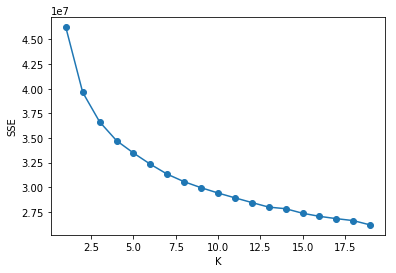

In [61]:
plt.plot(ks, scores, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('SSE')

In [43]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 9)
model_9 = kmeans.fit(azdias_pca)
azdias_modelled = model_9.predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

I chose to use 9 clusters. At 10 the difference in score plateaus and additional clusters seem to have a consistently small effect on score. For this reason, I believe 9 is the elbow and ideal number of clusters to use. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [44]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [45]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)


In [46]:
# Apply scaler
customers_clean_scaled = scaler.transform(customers_clean)
customers_clean_scaled = pd.DataFrame(customers_clean_scaled, columns=customers_clean.columns.tolist())
# PCA transformation
customers_pca = pca_40.transform(customers_clean_scaled)

In [47]:
# Predict using Kmeans model_12
customers_modeled = model_9.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [48]:
pd.Series(azdias_modelled).value_counts(normalize=True)

0    0.178326
2    0.176040
7    0.150046
4    0.134709
3    0.116220
1    0.090447
5    0.081292
8    0.066581
6    0.006339
dtype: float64

In [49]:
azdias_prop = pd.Series(azdias_modelled).value_counts(normalize=True)
df_azdias = pd.DataFrame(data=azdias_prop, columns=['prop'])
df_azdias['data_pop'] = 'azdias'


customers_prop = pd.Series(customers_modeled).value_counts(normalize=True)
df_customers = pd.DataFrame(data=customers_prop, columns=['prop'])
df_customers['data_pop'] = 'customers'

merged = pd.concat([df_azdias, df_customers])





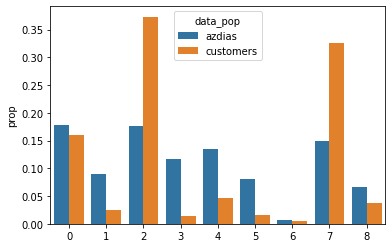

In [50]:
sns.barplot(data=merged, x=merged.index, y=merged.prop, hue=merged.data_pop)

In [51]:
def reverse_transform(pca_model, cluster_model, num):
    inverse = pd.Series(pca_model.inverse_transform(cluster_model.cluster_centers_[num]))
    return inverse


In [52]:
centroid_0 = reverse_transform(pca_40, model_9, 0)
centroid_1 = reverse_transform(pca_40, model_9, 1)
centroid_2 = reverse_transform(pca_40, model_9, 2)
centroid_3 = reverse_transform(pca_40, model_9, 3)
centroid_4 = reverse_transform(pca_40, model_9, 4)
centroid_5 = reverse_transform(pca_40, model_9, 5)
centroid_6 = reverse_transform(pca_40, model_9, 6)
centroid_7 = reverse_transform(pca_40, model_9, 7)
centroid_8 = reverse_transform(pca_40, model_9, 8)



In [53]:
df_inverse = pd.concat([centroid_0, centroid_1, centroid_2, centroid_3, centroid_4,centroid_5, centroid_6, centroid_7, centroid_8], axis=1)
df_inverse.index = azdias_clean_imputed.columns
df_inverse.columns = ['centroid_0', 'centroid_1','centroid_2', 'centroid_3', 'centroid_4', 'centroid_5', 'centroid_6', 'centroid_7','centroid_8']

In [54]:
pd.set_option('display.max_rows', 100)

In [55]:
df_inverse.centroid_4.sort_index(ascending=False)


W_KEIT_KIND_HH          -0.540757
WOHNDAUER_2008          -0.272024
WEALTH                  -0.513721
SOHO_KZ                  0.009445
SINGLE_PARENT            0.060435
SINGLE                  -0.657022
SEMIO_VERT              -0.157435
SEMIO_TRADV              0.482293
SEMIO_SOZ                0.147695
SEMIO_REL                0.898994
SEMIO_RAT                0.655060
SEMIO_PFLICHT            0.647539
SEMIO_MAT                0.420367
SEMIO_LUST              -0.463220
SEMIO_KULT               0.471297
SEMIO_KRIT              -0.293054
SEMIO_KAEM              -0.028982
SEMIO_FAM                0.267246
SEMIO_ERL               -0.223254
SEMIO_DOM               -0.206193
RURAL_NEIGHBERHOOD       0.400610
RETOURTYP_BK_S          -0.438759
RELAT_AB                -0.227194
REGIOTYP                -0.200790
PLZ8_HHZ                 0.490570
PLZ8_GBZ                 0.920222
PLZ8_ANTG4              -0.756565
PLZ8_ANTG3              -1.042667
PLZ8_ANTG2              -0.617850
PLZ8_ANTG1    

In [56]:
df_inverse.sort_index(ascending=False)

,centroid_0,centroid_1,centroid_2,centroid_3,centroid_4,centroid_5,centroid_6,centroid_7,centroid_8
W_KEIT_KIND_HH,-0.036275,-0.249420,-0.294970,-0.249858,-0.540757,-0.098382,-0.016974,-0.253843,-0.056655
WOHNDAUER_2008,-0.247740,-4.783407,-0.163551,-0.304898,-0.272024,-4.902548,-1.289905,-0.185576,-0.550078
WEALTH,0.065611,-0.442757,-0.554289,0.105194,-0.513721,0.130090,0.281759,-0.530008,0.169088
SOHO_KZ,0.007751,0.007798,0.009040,0.008357,0.009445,0.007193,0.008843,0.008736,0.007560
SINGLE_PARENT,0.018824,0.049670,0.023999,0.050687,0.060435,0.039941,0.012601,0.024556,0.019504
SINGLE,-0.382389,-0.393914,-0.643289,-0.419059,-0.657022,-0.279754,-0.301183,-0.598087,-0.333724
SEMIO_VERT,-0.204739,-0.214115,-0.113559,-0.269675,-0.157435,-0.242178,-0.210311,-0.127571,-0.225716
SEMIO_TRADV,-0.490027,0.066930,-0.404829,0.433171,0.482293,0.147364,-0.154634,-0.345327,-0.189424
SEMIO_SOZ,-0.000658,0.000510,-0.050826,0.171526,0.147695,0.135733,0.148611,-0.047047,0.066219
SEMIO_REL,-0.658495,0.156394,-0.552936,0.987661,0.898994,0.450128,0.072803,-0.510861,-0.034334


In [57]:
pd.concat([df_inverse.centroid_0.sort_values(ascending=False).head(10), df_inverse.centroid_0.sort_values(ascending=False).tail(10)], axis=0)


KBA05_ANTG3            1.379415
FAMILY_HOMES           0.844545
ARBEIT                 0.681315
PLZ8_HHZ               0.613148
ANZ_HAUSHALTE_AKTIV    0.531953
SEMIO_ERL              0.517915
ORTSGR_KLS9            0.505545
FINANZ_HAUSBAUER       0.478671
PLZ8_ANTG2             0.460086
RELAT_AB               0.372458
GEBAEUDETYP_RASTER    -0.385324
ONLINE_AFFINITAET     -0.413642
PLZ8_ANTG1            -0.417542
INNENSTADT            -0.420421
ANREDE_KZ             -0.449463
MOBI_REGIO            -0.473917
SEMIO_TRADV           -0.490027
DECADE                -0.506784
SEMIO_RAT             -0.527908
SEMIO_REL             -0.658495
Name: centroid_0, dtype: float64

In [58]:
def plot_scaled_comparison_sorted(cluster_series, n):
    data = pd.concat([cluster_series.sort_values(ascending=False).head(n),cluster_series.sort_values(ascending=False).tail(n)], axis=0)
    fig= plt.figure(figsize=(22,16))
    data.plot(kind='barh')

In [59]:
def plot_scaled_comparison_alphabetical(cluster_series):
    data = cluster_series.sort_index(ascending=False)
    fig= plt.figure(figsize=(22,16))
    data.plot(kind='barh')

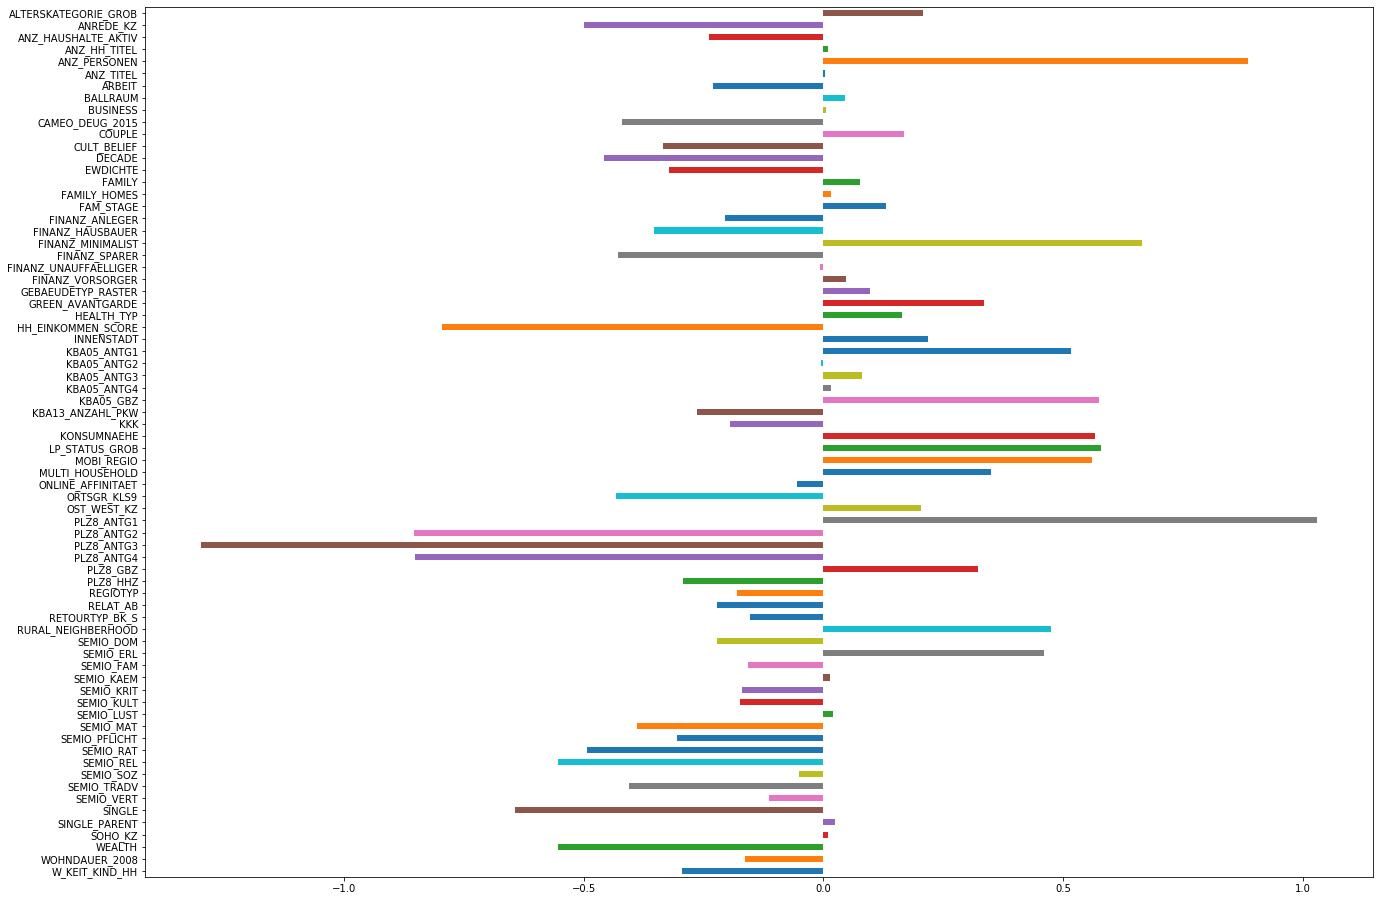

In [78]:
plot_scaled_comparison_alphabetical(df_inverse.centroid_2)

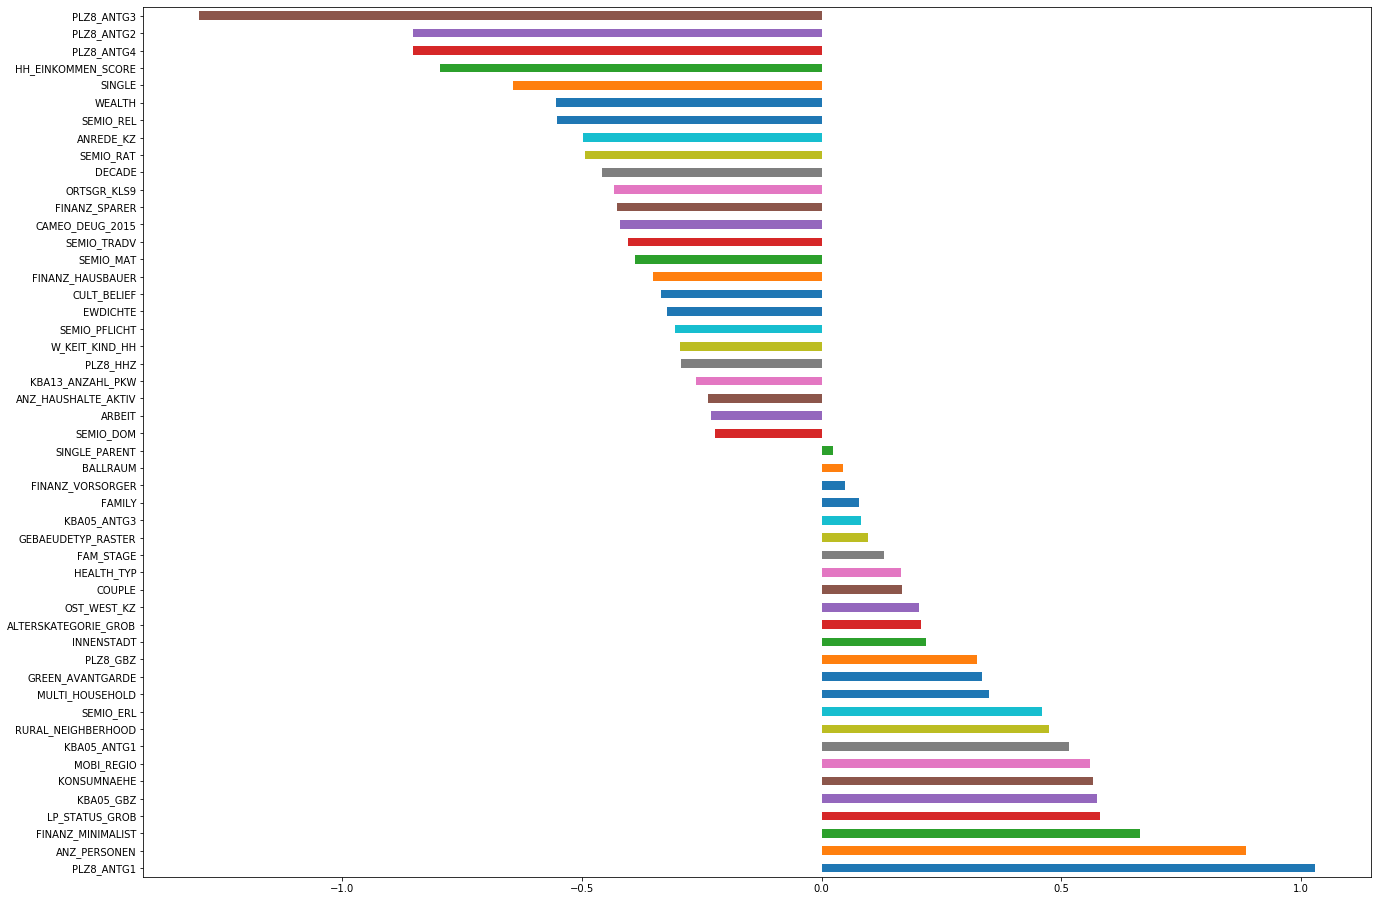

In [70]:
plot_scaled_comparison_sorted(df_inverse.centroid_2, 25)


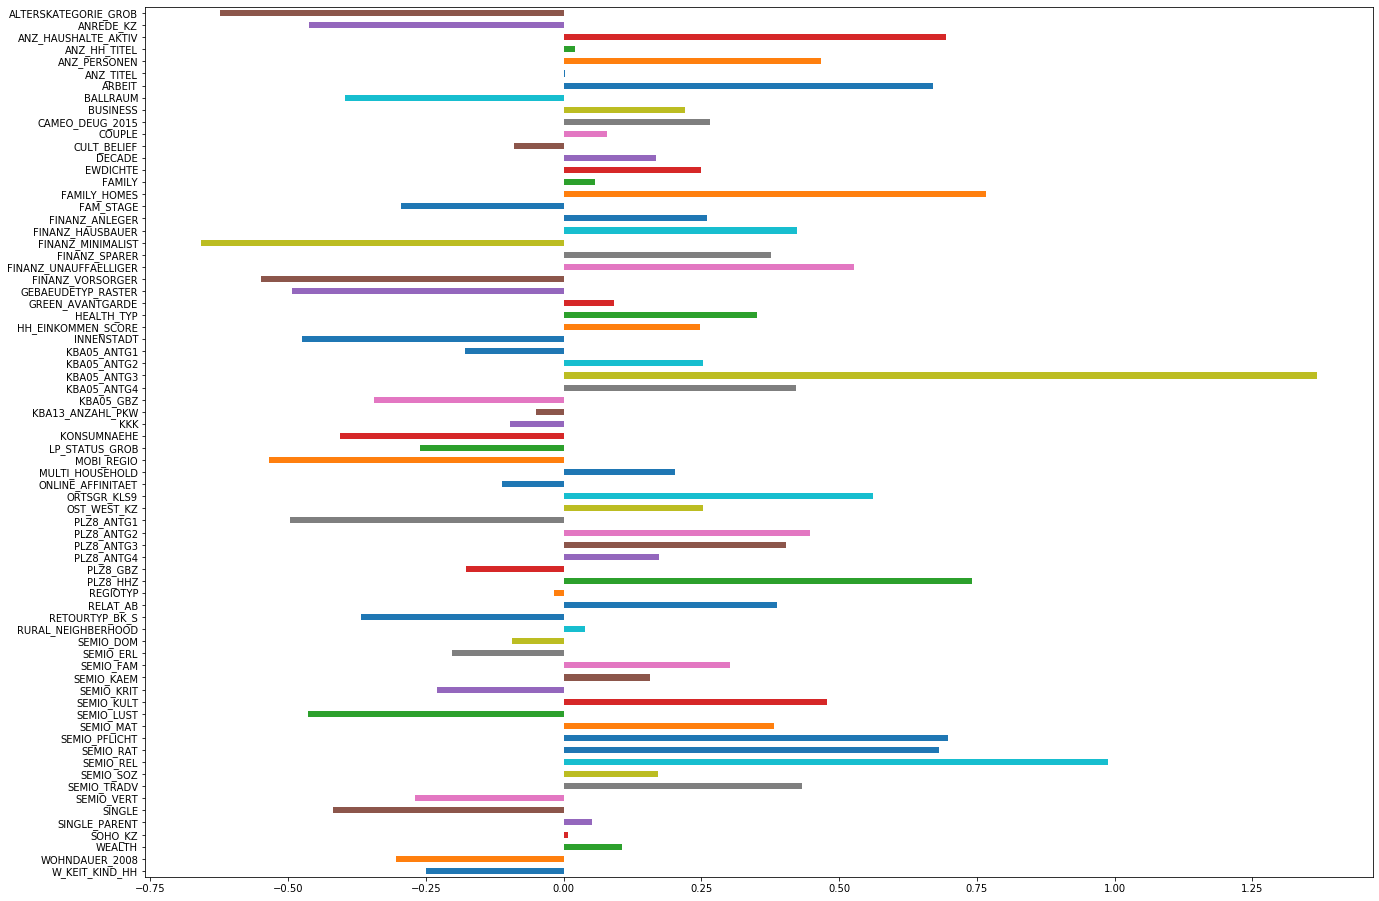

In [79]:
plot_scaled_comparison_alphabetical(df_inverse.centroid_3)

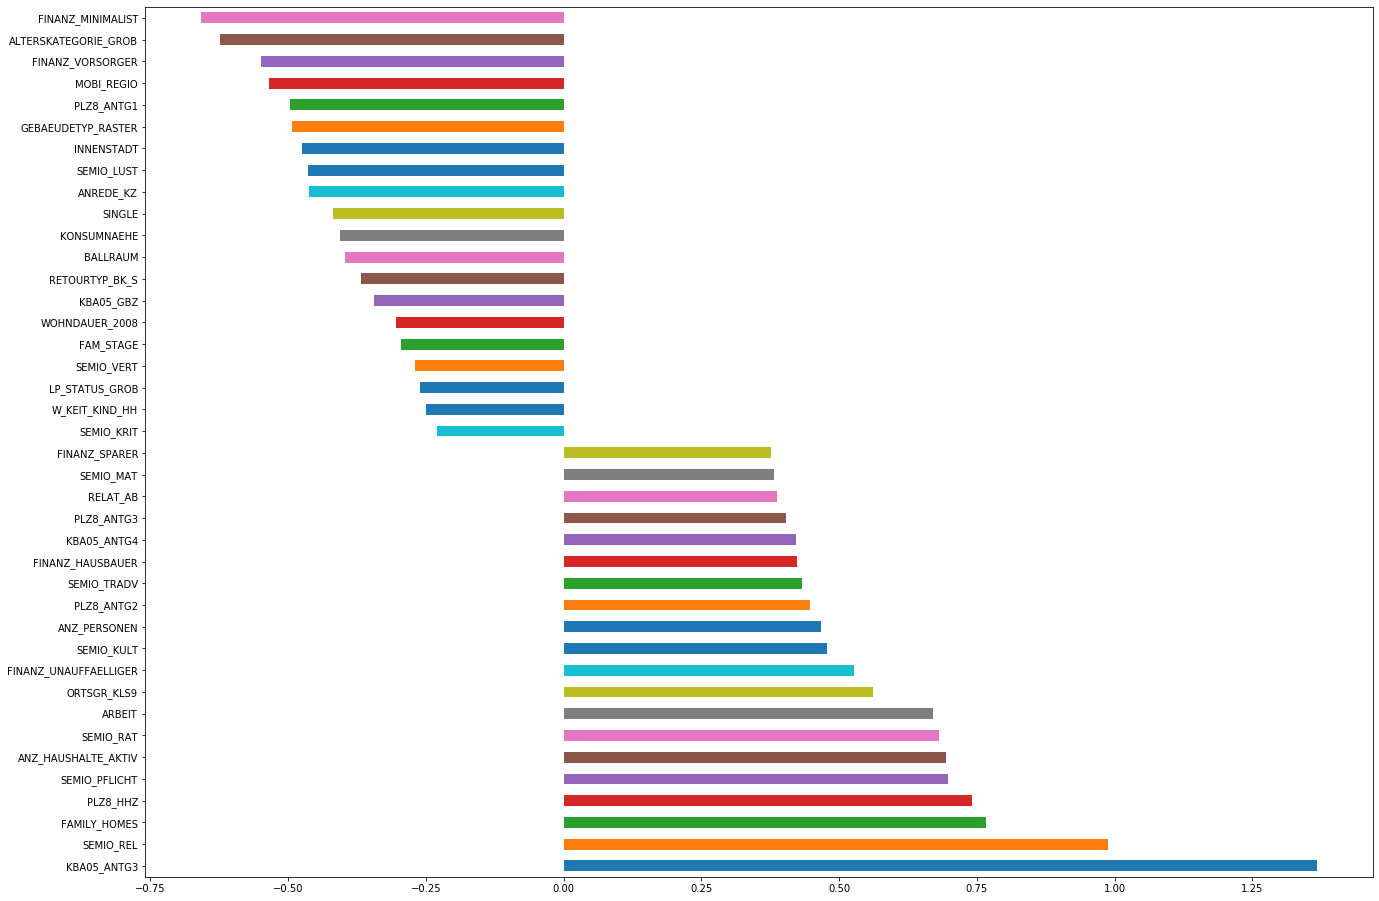

In [73]:
plot_scaled_comparison_sorted(df_inverse.centroid_3,20)

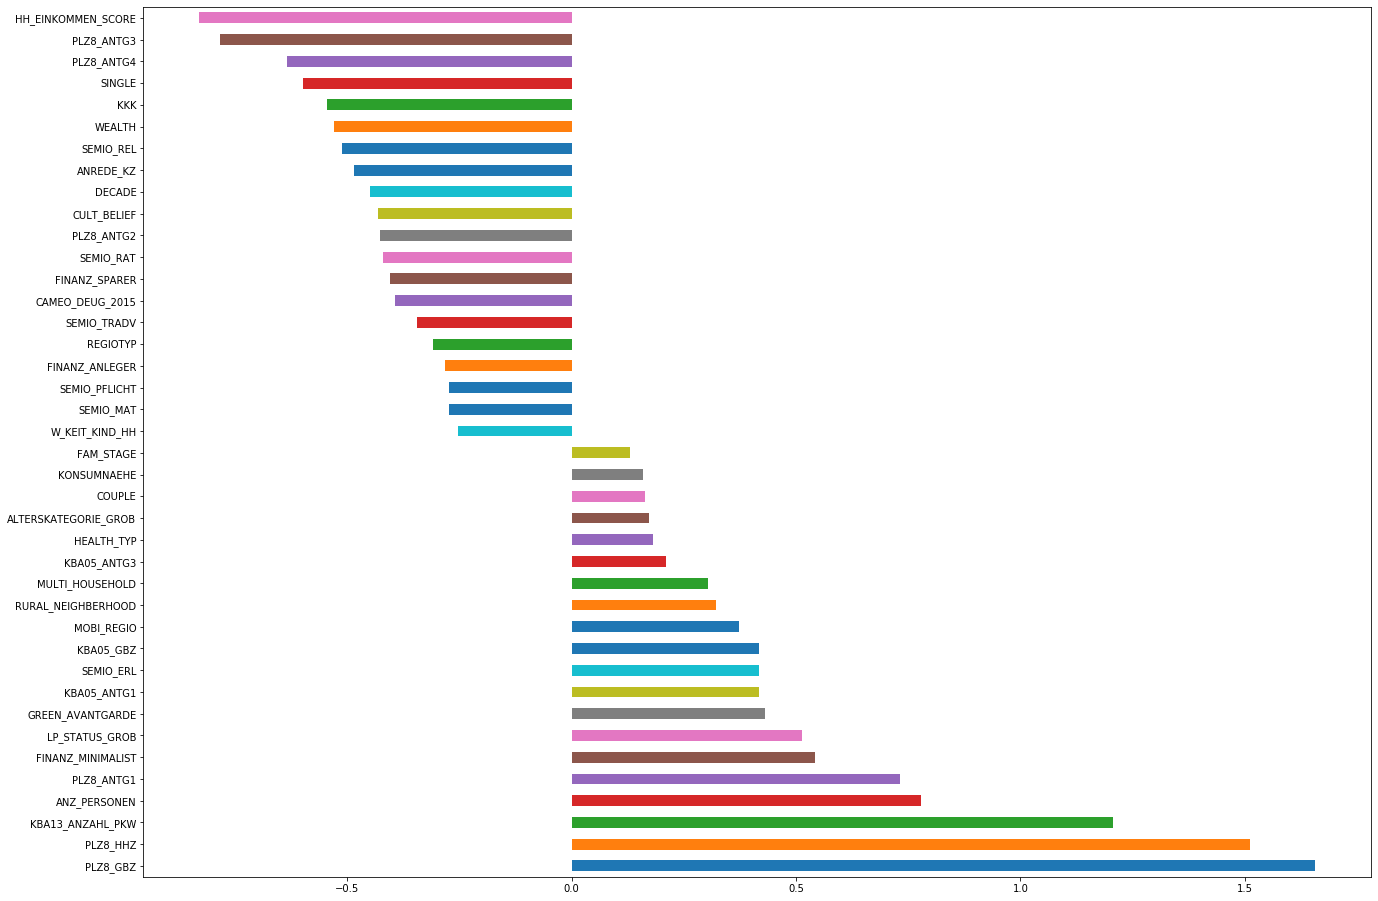

In [74]:
plot_scaled_comparison_sorted(df_inverse.centroid_7, 20)

### Discussion 3.3: Compare Customer Data to Demographics Data

Overrepresent in the mail-order companies customer data set are wealthy, middle-aged adults (average born in the 70's), who are traditional and rationally minded. They are money savers and typically own houses. 

There are a few clusters underepresented. These clusters seem to share some common characteristics. They are average to low income earners, typically are less family and religious minded. They are typically younger (averge born in the 90's). They are more sensual and event minded, and they are less financially inclined. 
                                                                                             

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.